In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall

Im vorliegenden Notebook wird der Deep-Learning-Ansatz erweitert. Die Datenvorverarbeitungsschritte sind in großen Teilen identisch mit denen,
die bei den klassischen ML-Verfahren angewendet wurden. Im Anschluss daran wird unser neuer Ansatz, ein Deep Neural Decision Tree, untersucht.

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, f1, prec, rec, mcc

In [4]:
df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')
df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2
for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 
target='AT_RISK'

discarded_features = ['MEDICAL_UNIT', 'USMER','DIED','ICU','INTUBED','PATIENT_TYPE']
df = df.drop(discarded_features, axis=1)

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.017308
ASTHMA     -0.017983
TOBACCO     0.005573
Name: AT_RISK, dtype: float64


In [5]:
#Wir wandeln die kategoriellen Werte des Attributs 'CLASIFFICATION_FINAL' in One-Hot-codierte Dummy-Werte um.
df = pd.get_dummies(df,columns=["CLASIFFICATION_FINAL"],drop_first=True)

In [6]:
#Wir wenden wieder eine Form des balancierten zufälligen Undersamplings an. Zu den Zeilen mit positivem
#Label wird die gleiche Anzahl an Zeilen mit negativem Label zufällig aus der Gesamtmenge aller
#Zeilen mit negativem Label gezogen und konkateniert.

df_dead = df[df["AT_RISK"]==1].copy()
df_alive = df[df["AT_RISK"]==0].sample(n=len(df_dead))

#Wir teilen den Datensatz in Trainings- und Testdatensatz im Verhältnis 90 zu 10 auf. 

test_size_dead=0.1
train_dead, test_dead = train_test_split(df_dead, test_size=test_size_dead, shuffle=True)

test_size_alive=0.1
train_alive, test_alive = train_test_split(df_alive, test_size=test_size_alive, shuffle=True)

train = pd.concat([train_dead, train_alive], axis=0)
test = pd.concat([test_dead, test_alive], axis=0)

train_y = train[target]
train_x = train.drop(target,axis=1)

test_y = test[target]
test_x = test.drop(target,axis=1)

/Users/sebastianbender/Documents/programming/fernuni/covid-19-risiko-erkennung/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation Loss: 0.3311
Best Validation Accuracy: 0.8668
537/537 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.8651357967129036
F1: 0.8677411979881116
Precision: 0.8512952786811708
Recall: 0.8848350623615806
Mcc: 0.7308390340638149



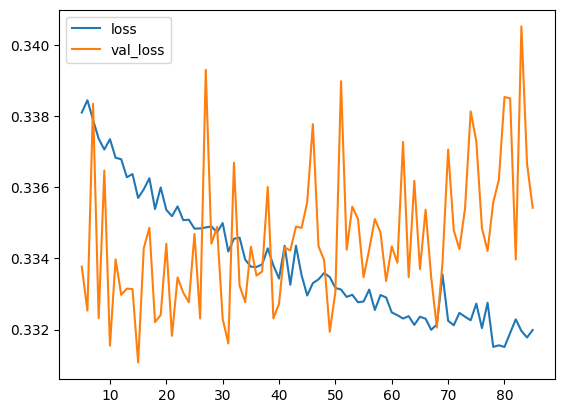

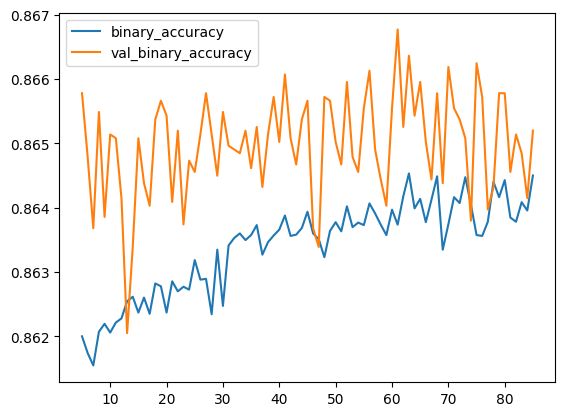

In [7]:
#Wir erweitern die Parameter unseres Multi-Layer-Perzeptrons, indem wir nun vier verdeckte Schichten mit wesentlich
#mehr Neuronen ansetzen. Weiterhin passen wir die Lernrate, den Stopp-Mechanismus und die Batch-Größe an. 

model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=[train_x.shape[1]]),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.optimizer.learning_rate.assign(10e-3)

early_stopping = keras.callbacks.EarlyStopping(patience=75, min_delta=0.001, restore_best_weights=True)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), batch_size=256, epochs=1000,
                    callbacks=[early_stopping], verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history_df['val_loss'].min(),
                  history_df['val_binary_accuracy'].max()))

y_pred = (model.predict(test_x) > 0.5).astype("int32")
acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")


Im Folgenden implementieren wir unseren neuen Ansatz, nämlich den Deep Neural Decision Tree (DNDT). 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from collections import OrderedDict
import graphviz

In [8]:
#Das verwendete Gerät (GPU oder CPU) wird ausgewählt.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
#Der Datensatz muss zuerst in ein passendes Eingabeformat (tabuläres Dataset) für torch umgewandelt werden. 
#Die folgende Klasse definiert die entsprechenden Instanzen.

class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float64)
        self.labels = torch.tensor(labels).type(torch.LongTensor)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx].to(device), self.labels[idx].to(device)


In [10]:
#Die Daten werden in das Eingabeformat umgewandelt. 
train_dataset = TabularDataset(train_x.astype(np.float64).values, train_y.astype(np.float64).values)
test_dataset = TabularDataset(test_x.astype(np.float64).values, test_y.astype(np.float64).values)

#Diese werden Datenlader-Objekten übergeben.
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [11]:
# ----------------------------
# DNDT Model Definition
# ----------------------------
class DNDT(nn.Module):
    def __init__(self, n_features, n_classes, depth=3, alpha=10.0):
        """
        Implementierung eines Deep Neural Decision Trees (DNDT) als pytorch-Modell.
        - n_features: Anzahl der Input Features.
        - n_classes: Anzahl der target Klassen.
        - depth: Baumtiefe (Anzahl der Entscheidungen auf einem beliebigen Pfad von Root zu Leaf).
          Insgesamt (2**depth - 1) interne Nodes und 2**depth Leaves.
        - alpha: Skalierungsfaktor für die Sigmoid-Funktion (kontrolliert, wie "hart" die Entscheidungen sind).
        """
        super(DNDT, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.depth = depth
        self.num_internal = 2 ** depth - 1
        self.num_leaves = 2 ** depth
        self.alpha = alpha

        # Jeder interne Node hat:
        #  - einen learnbaren Vektor für die Feature-Auswahl (vor der Softmax-Funktion)
        #  - einen learnbaren Schwellwert (vor der Sigmoid-Funktion) im Bereich [0, 1]
        self.feature_selectors = nn.ParameterList([
            nn.Parameter(torch.randn(n_features)) for _ in range(self.num_internal)
        ])
        # Initialisiert die Schwellwerte auf 0, sodass sigmoid(0)=0.5.
        self.threshold_raw = nn.ParameterList([
            nn.Parameter(torch.tensor(0.0)) for _ in range(self.num_internal)
        ])

        # Jeder Leaf hält einen learnbaren Logit-Vektor für die Klassifikation.
        self.leaf_logits = nn.Parameter(torch.randn(self.num_leaves, n_classes))

        # Vorverarbeitung der Pfade für jedes Leaf.
        self.leaf_paths = self._compute_leaf_paths()

    def _compute_leaf_paths(self):
        """
        Berechnet die Routing-Pfade für jedes Leaf.
        Für einen Baum der Tiefe D wird jedes Leaf durch D Entscheidungen erreicht.
        Wir interpretieren den Index eines Blattes binär (mit D Bits), wobei bit=1 bedeutet, den linken Zweig zu nehmen
        und bit=0 bedeutet, den rechten Zweig zu nehmen.
        Danach können wir die entsprechenden internen Knotenindizes berechnen (unter der Annahme, dass interne Knoten von 0 an nummeriert sind).
        """
        leaf_paths = []
        for leaf in range(self.num_leaves):
            bin_str = format(leaf, '0{}b'.format(self.depth))  
            path = []
            offset = 0  # Position im aktuellen Level
            for d, bit in enumerate(bin_str):
                node_index = (2 ** d - 1) + offset  # Aktueller interner Knotenindex
                decision = 1 if bit == '1' else 0
                path.append((node_index, decision))

                if decision == 1:
                    offset = offset * 2      # left child
                else:
                    offset = offset * 2 + 1  # right child
            leaf_paths.append(path)
        return leaf_paths

    def forward(self, x):
        """
        Forward pass:
          - Für jeden internen Node wird eine weiche Entscheidung getroffen:
                p = sigmoid(alpha * (weighted_feature - threshold))
            wobei weighted_feature als das Skalarprodukt des Eingangs x berechnet wird
            mit einem Softmax über den lernbaren Feature-Auswahlvektor.
          - Für jedes Leaf wird die Routing-Wahrscheinlichkeit als Produkt der Entscheidungen entlang seines Pfades berechnet.
          - Der finale Output ist die gewichtete Summe über die Logit-Vektoren der Leaves.
        """
        batch_size = x.shape[0]
        device = x.device

        p_all = []
        for i in range(self.num_internal):
            # Compute a soft selection over features. 
            weights = torch.softmax(self.feature_selectors[i], dim=0)  
            # Berechnet den gewichteten Feature-Wert.
            feat_val = (x * weights).sum(dim=1)  
            # Entscheidungsschwelle auf [0, 1] beschränken.
            threshold = torch.sigmoid(self.threshold_raw[i])
            # Berechne soft decision
            p = torch.sigmoid(self.alpha * (feat_val - threshold))
            p_all.append(p.unsqueeze(1))
        p_all = torch.cat(p_all, dim=1) 

        # Berechne die Routing-Wahrscheinlichkeit für jedes Leaf.
        leaf_probs = []
        for path in self.leaf_paths:
            prob = torch.ones(batch_size, device=device)
            for (node_idx, decision) in path:
                p_val = p_all[:, node_idx]  
                prob = prob * (p_val if decision == 1 else (1 - p_val))
            leaf_probs.append(prob.unsqueeze(1))
        leaf_probs = torch.cat(leaf_probs, dim=1)  

        # Final output: gewichtete Summe über die Logit-Vektoren der Leaves.
        out = leaf_probs @ self.leaf_logits 
        return out

In [12]:
#Die folgende Funktion implementiert das Training eines DNDT.

def train_model(model, dataloader, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)  
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0)
        avg_loss = total_loss / len(dataloader.dataset)
        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [41]:
def visualize_dndt(model, feature_names=None, filename='dndt_tree'):
    """
    Visualisierung des trainierten DNDT mit graphviz.
    Für jeden internen Knoten wird das ausgewählte Feature (via argmax der Softmax)
    und der effektive Schwellenwert (nach Sigmoid) angezeigt. Für jedes Blatt wird die
    vorhergesagte Klasse (argmax der Logits) und die Logit-Werte angezeigt.
    """
    import graphviz
    import numpy as np

    fontsize = '8'

    dot = graphviz.Digraph(comment="Deep Neural Decision Tree", format='png')
    dot.attr('graph', rankdir='TB', nodesep='0.1', ranksep='0.3', margin='0.1')
    dot.attr('node', shape='box', style='filled,rounded', fontname='Helvetica', fontsize=fontsize)

    num_internal = model.num_internal

    def add_node(node_idx):
        node_name = f'node_{node_idx}'
        # Effektiver Schwellenwert durch Anwendung von Sigmoid.
        threshold = torch.sigmoid(model.threshold_raw[node_idx]).item()

        fs = torch.softmax(model.feature_selectors[node_idx], dim=0)
        feat_idx = int(torch.argmax(fs).item())
        feature_label = feature_names[feat_idx] if feature_names is not None else f'X[{feat_idx}]'
        label = f"{node_name}\n{feature_label} > {threshold:.2f}"
        dot.node(node_name, label=label)

        left_idx = 2 * node_idx + 1
        right_idx = 2 * node_idx + 2

        # Linker Pfad, wenn die Bedingung erfüllt ist.
        if left_idx < num_internal:
            add_node(left_idx)
            dot.edge(node_name, f'node_{left_idx}', label='Yes', fontsize=fontsize)
        else:
            # Compute the leaf index and label.
            leaf_id = left_idx - num_internal
            leaf_logits = model.leaf_logits[leaf_id].detach().cpu().numpy()
            predicted_class = int(np.argmax(leaf_logits))
            leaf_label = (f"Leaf {leaf_id}\n"
                          f"class = {predicted_class}\n"
                          f"logits = {np.array2string(leaf_logits, precision=2, separator=',')}")
            dot.node(f'leaf_{leaf_id}', label=leaf_label)
            dot.edge(node_name, f'leaf_{leaf_id}', label='Yes', fontsize=fontsize)

        # Rechter Pfad, wenn die Bedingung nicht erfüllt ist.
        if right_idx < num_internal:
            add_node(right_idx)
            dot.edge(node_name, f'node_{right_idx}', label='No', fontsize=fontsize)
        else:
            leaf_id = right_idx - num_internal
            leaf_logits = model.leaf_logits[leaf_id].detach().cpu().numpy()
            predicted_class = int(np.argmax(leaf_logits))
            leaf_label = (f"Leaf {leaf_id}\n"
                          f"class = {predicted_class}\n"
                          f"logits = {np.array2string(leaf_logits, precision=2, separator=',')}")
            dot.node(f'leaf_{leaf_id}', label=leaf_label)
            dot.edge(node_name, f'leaf_{leaf_id}', label='No', fontsize=fontsize)

    add_node(0)

    dot.render(filename, view=True)
    return dot


In [46]:
depth = 3
model = DNDT(train_x.shape[1], 2, depth=depth, alpha=10.0).double().to(device)


criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, num_epochs=150, learning_rate=0.0001)

Epoch 1/150, Loss: 0.7437
Epoch 2/150, Loss: 0.7015
Epoch 3/150, Loss: 0.6585
Epoch 4/150, Loss: 0.6177
Epoch 5/150, Loss: 0.5797
Epoch 6/150, Loss: 0.5453
Epoch 7/150, Loss: 0.5156
Epoch 8/150, Loss: 0.4916
Epoch 9/150, Loss: 0.4729
Epoch 10/150, Loss: 0.4589
Epoch 11/150, Loss: 0.4484
Epoch 12/150, Loss: 0.4404
Epoch 13/150, Loss: 0.4343
Epoch 14/150, Loss: 0.4296
Epoch 15/150, Loss: 0.4258
Epoch 16/150, Loss: 0.4227
Epoch 17/150, Loss: 0.4201
Epoch 18/150, Loss: 0.4180
Epoch 19/150, Loss: 0.4161
Epoch 20/150, Loss: 0.4146
Epoch 21/150, Loss: 0.4131
Epoch 22/150, Loss: 0.4118
Epoch 23/150, Loss: 0.4106
Epoch 24/150, Loss: 0.4095
Epoch 25/150, Loss: 0.4084
Epoch 26/150, Loss: 0.4073
Epoch 27/150, Loss: 0.4062
Epoch 28/150, Loss: 0.4051
Epoch 29/150, Loss: 0.4040
Epoch 30/150, Loss: 0.4029
Epoch 31/150, Loss: 0.4019
Epoch 32/150, Loss: 0.4008
Epoch 33/150, Loss: 0.3996
Epoch 34/150, Loss: 0.3984
Epoch 35/150, Loss: 0.3972
Epoch 36/150, Loss: 0.3959
Epoch 37/150, Loss: 0.3945
Epoch 38/1

In [49]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)

acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")

Accuracy: 0.8628628045226716
F1: 0.8641219610787088
Precision: 0.8562600137331197
Recall: 0.8721296188366943
Mcc: 0.7258502828655251



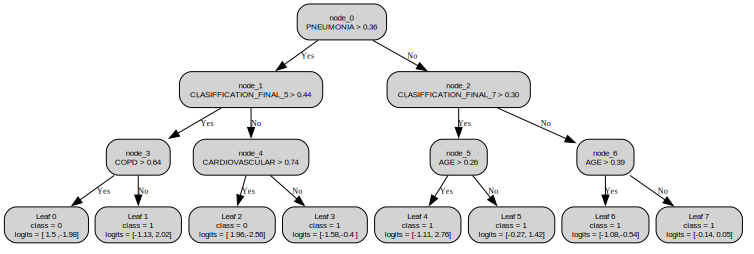

In [48]:
# Visualisierung des trainierten DNDT
visualize_dndt(model, feature_names=list(test_x.columns), filename='dndt_tree')

Der DNDT kann auch in Form eines Deep Neural Random Forests (DNDF) verwendet werden. Dies wird im Folgenden
implementiert.

In [24]:
class DNDF(nn.Module):
    def __init__(self, num_trees, depth, num_features, num_classes):
        super(DNDF, self).__init__()
        self.ensemble = nn.ModuleList()
        self.num_classes = num_classes
        self.num_trees = num_trees

        for _ in range(num_trees):
            self.ensemble.append(
                DNDT(num_features, num_classes, depth)
            )

    def forward(self, x):
        batch_size = x.shape[0]
        outputs = torch.zeros((batch_size, self.num_classes))

        for tree in self.ensemble:
            outputs += tree(x)

        outputs /= len(self.ensemble)
        return outputs

In [25]:
model = DNDF(10, 5, train_x.shape[1], 2)
model = model.double().to(device)

criterion = nn.CrossEntropyLoss()

train_model(model, train_loader, num_epochs=100, learning_rate=0.0001)

Epoch 1/100, Loss: 0.6703
Epoch 2/100, Loss: 0.6419
Epoch 3/100, Loss: 0.6136
Epoch 4/100, Loss: 0.5849
Epoch 5/100, Loss: 0.5559
Epoch 6/100, Loss: 0.5278
Epoch 7/100, Loss: 0.5021
Epoch 8/100, Loss: 0.4796
Epoch 9/100, Loss: 0.4603
Epoch 10/100, Loss: 0.4439
Epoch 11/100, Loss: 0.4301
Epoch 12/100, Loss: 0.4188
Epoch 13/100, Loss: 0.4097
Epoch 14/100, Loss: 0.4024
Epoch 15/100, Loss: 0.3967
Epoch 16/100, Loss: 0.3920
Epoch 17/100, Loss: 0.3880
Epoch 18/100, Loss: 0.3846
Epoch 19/100, Loss: 0.3815
Epoch 20/100, Loss: 0.3788
Epoch 21/100, Loss: 0.3762
Epoch 22/100, Loss: 0.3740
Epoch 23/100, Loss: 0.3719
Epoch 24/100, Loss: 0.3700
Epoch 25/100, Loss: 0.3682
Epoch 26/100, Loss: 0.3667
Epoch 27/100, Loss: 0.3652
Epoch 28/100, Loss: 0.3639
Epoch 29/100, Loss: 0.3627
Epoch 30/100, Loss: 0.3616
Epoch 31/100, Loss: 0.3606
Epoch 32/100, Loss: 0.3597
Epoch 33/100, Loss: 0.3588
Epoch 34/100, Loss: 0.3581
Epoch 35/100, Loss: 0.3574
Epoch 36/100, Loss: 0.3568
Epoch 37/100, Loss: 0.3562
Epoch 38/1

In [26]:
model.eval()
L = np.empty((0, 2))
for X, y in test_loader:
    test_out = model(X).detach().cpu().numpy()
    L = np.append(L, test_out, axis=0)

y_pred = L.argmax(axis=1)

acc, f1, prec, rec, mcc = get_scores(test_y, y_pred)
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Precision: {prec}')
print(f'Recall: {rec}')
print(f'Mcc: {mcc}'+"\n")

Accuracy: 0.863095931926798
F1: 0.8630719906732731
Precision: 0.863222947761194
Recall: 0.8629210863737032
Mcc: 0.7261919082543756

